In [1]:
import datetime
from IPython.display import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/f

In [2]:
# MNIST 데이터를 불러옵니다.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

/home/crypto736/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/datas

In [3]:
# 생성된 MNIST 이미지를 8x8 Grid로 보여주는 plot 함수를 정의합니다.
def plot(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        plt.imshow(sample.reshape(28, 28))
    return fig

In [4]:
# 설정값들을 선언합니다.
num_epoch = 100000
batch_size = 64
num_input = 28 * 28
num_latent_variable = 100
num_hidden = 128
learning_rate = 0.001

In [5]:
# 플레이스 홀더를 선언합니다.
X = tf.placeholder(tf.float32, [None, num_input])               # 인풋 이미지
z = tf.placeholder(tf.float32, [None, num_latent_variable])     # 인풋 Latent Variable

In [6]:
# Generator 변수들 설정 
# 100 -> 128 -> 784
with tf.variable_scope('generator'):
    # 히든 레이어 파라미터 
    G_W1 = tf.Variable(tf.random_normal(shape=[num_latent_variable, num_hidden], stddev=0.02))   
    G_b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    # 아웃풋 레이어 파라미터
    G_W2 = tf.Variable(tf.random_normal(shape=[num_hidden, num_input], stddev=0.02))   
    G_b2 = tf.Variable(tf.constant(0.1, shape=[num_input]))

In [7]:
# Discriminator 변수들 설정 
# 784 -> 128 -> 1
with tf.variable_scope('discriminator'):
    # 히든 레이어 파라미터
    D_W1 = tf.Variable(tf.random_normal(shape=[num_input, num_hidden], stddev=0.02))   
    D_b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    # 아웃풋 레이어 파라미터
    D_W2 = tf.Variable(tf.random_normal(shape=[num_hidden, 1], stddev=0.02))   
    D_b2 = tf.Variable(tf.constant(0.1, shape=[1]))

In [8]:
# Generator를 생성하는 함수를 정의합니다.
# Inputs:
#   X : 인풋 Latent Variable
# Output:
#   generated_mnist_image : 생성된 MNIST 이미지
def build_generator(X):
    hidden_layer = tf.nn.relu((tf.matmul(X, G_W1) + G_b1))
    output_layer = tf.matmul(hidden_layer, G_W2) + G_b2
    generated_mnist_image = tf.nn.sigmoid(output_layer)

    return generated_mnist_image

In [9]:
# Discriminator를 생성하는 함수를 정의합니다.
# Inputs:
#   X : 인풋 이미지
# Output:
#   predicted_value : Discriminator가 판단한 True(1) or Fake(0)
#   logits : sigmoid를 씌우기전의 출력값
def build_discriminator(X):
    hidden_layer = tf.nn.relu((tf.matmul(X, D_W1) + D_b1))
    logits = tf.matmul(hidden_layer, D_W2) + D_b2
    predicted_value = tf.nn.sigmoid(logits)

    return predicted_value, logits

In [10]:
# 생성자(Generator)를 선언합니다.
G = build_generator(z)

In [11]:
# 구분자(Discriminator)를 선언합니다.
D_real, D_real_logits = build_discriminator(X)  # D(x)
D_fake, D_fake_logits = build_discriminator(G)  # D(G(z))

In [12]:
# Discriminator의 손실 함수를 정의합니다.
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)))    # log(D(x))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)))   # log(1-D(G(z)))
d_loss = d_loss_real + d_loss_fake  # log(D(x)) + log(1-D(G(z)))

In [13]:
# Generator의 손실 함수를 정의합니다.
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)))         # log(D(G(z))

In [14]:
# 전체 파라미터를 Discriminator와 관련된 파라미터와 Generator와 관련된 파라미터로 나눕니다.
tvar = tf.trainable_variables()
dvar = [var for var in tvar if 'discriminator' in var.name]
gvar = [var for var in tvar if 'generator' in var.name]

In [15]:
# Discriminator와 Generator의 Optimizer를 정의합니다.
d_train_step = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=dvar)
g_train_step = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=gvar)

In [16]:
# 생성된 이미지들을 저장할 generated_outputs 폴더를 생성합니다.
num_img = 0
if not os.path.exists('generated_output/'):
    os.makedirs('generated_output/')

In [17]:
start_time = datetime.datetime.now()

In [18]:
with tf.Session() as sess:
    # 변수들에 초기값을 할당합니다.
    sess.run(tf.global_variables_initializer())

    # num_epoch 횟수만큼 최적화를 수행합니다.
    for i in range(num_epoch):
        # MNIST 이미지를 batch_size만큼 불러옵니다. 
        batch_X, _ = mnist.train.next_batch(batch_size)
        # Latent Variable의 인풋으로 사용할 noise를 Uniform Distribution에서 batch_size만큼 샘플링합니다.
        batch_noise = np.random.uniform(-1., 1., [batch_size, 100])

        # 500번 반복할때마다 생성된 이미지를 저장합니다.
        if i % 500 == 0:
            samples = sess.run(G, feed_dict={z: np.random.uniform(-1., 1., [64, 100])})
            fig = plot(samples)
            plt.savefig('generated_output/%s.png' % str(num_img).zfill(3), bbox_inches='tight')
            num_img += 1
            plt.close(fig)

        # Discriminator 최적화를 수행하고 Discriminator의 손실함수를 return합니다.
        _, d_loss_print = sess.run([d_train_step, d_loss], feed_dict={X: batch_X, z: batch_noise})

        # Generator 최적화를 수행하고 Generator 손실함수를 return합니다.
        _, g_loss_print = sess.run([g_train_step, g_loss], feed_dict={z: batch_noise})

end_time= datetime.datetime.now()
learning_time = end_time - start_time
print('훈련시간: %d 마이크로초' % learning_time.microseconds)
print('훈련시간: %d 초' % learning_time.seconds)

훈련시간: 533790 마이크로초
훈련시간: 751 초


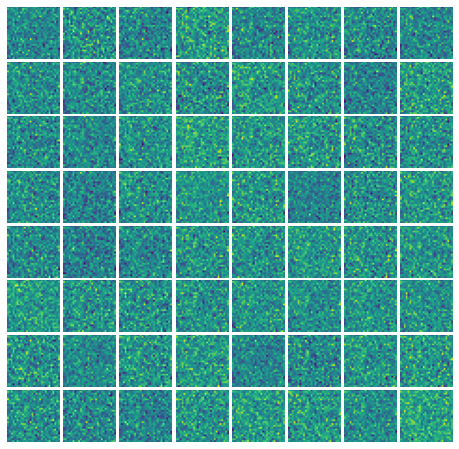

In [19]:
Image('generated_output/000.png')

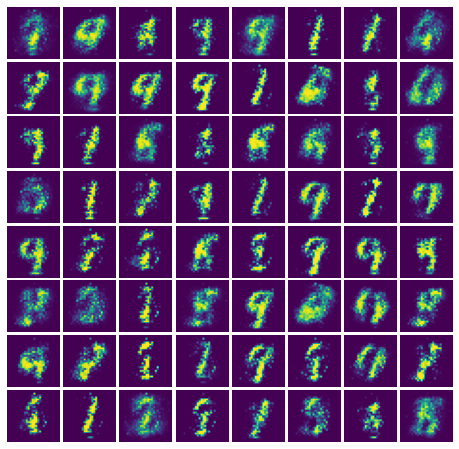

In [20]:
Image('generated_output/009.png')

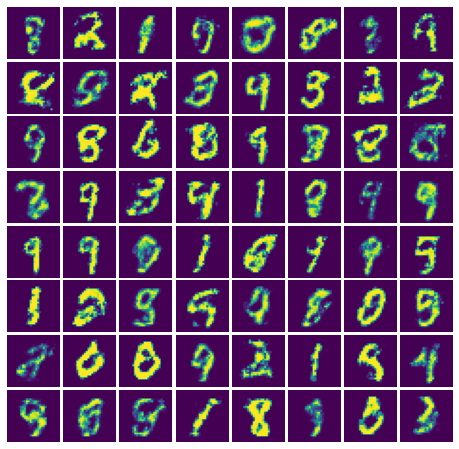

In [21]:
Image('generated_output/099.png')

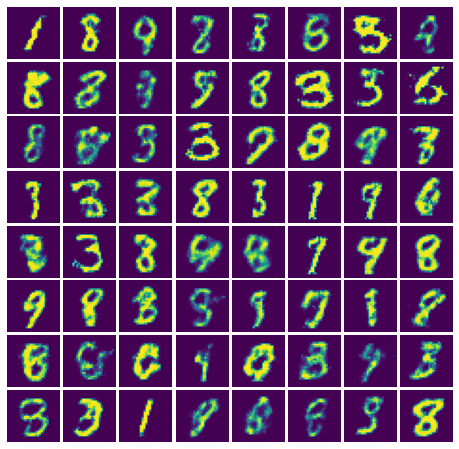

In [22]:
Image('generated_output/199.png')